# Single Subject Segmentation Q1K

In [9]:
##use these commented parameters for testing this notebook outside of the automated loop of q1k_automated_reports.ipynb
#subject_id = "10043F1"
#task_id = "TO"
#session_id = "01"
#run_id = "1"

#use these parameters when executing this notebook from the automation notebook..
subject_id = ""
task_id = ""
session_id = ""
run_id = ""


In [10]:
# import packages
#import q1k_sync_tools as qst
import mne
import mne_bids
#mne.viz.set_browser_backend('qt')
#%matplotlib qt
#pd.options.mode.chained_assignment = None
#import pylossless as ll
import numpy as np
import pandas as pd
#import glob

import matplotlib.pyplot as plt

from pathlib import Path
import shutil
import pylossless as ll

import warnings
warnings.filterwarnings('ignore')


# Set the parameters and read the pylossless data.

In [11]:
project_path = "/project/def-emayada/q1k/experimental/hsj/"
pylossless_path = "derivatives/pylossless/"
postproc_path = "derivatives/postproc/"
#task_id_in = "VEP"
#task_id_out = "VEP"
#subject_id = '096'
#session_id = '01'

bids_path = mne_bids.BIDSPath(
    subject=subject_id, session=session_id, task=task_id, run="1", datatype="eeg", suffix="eeg",root=project_path + pylossless_path
)
print(bids_path)

/project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/eeg/sub-10043F1_ses-01_task-TO_run-1_eeg.edf


In [12]:
# Read the BIDS pylossless output file..
eeg_raw = mne_bids.read_raw_bids(bids_path=bids_path, verbose=False)

# Interpret the annotations and apply the data selections.

In [13]:
# Get the events form the annotations
eeg_events, eeg_event_dict  = mne.events_from_annotations(eeg_raw)

Used Annotations descriptions: ['DIN4', 'Dev4', 'Dev5', 'Dev6', 'Dev7', 'Dev8', 'Dev9', 'SO41', 'SO42', 'SO43', 'SO44', 'SO51', 'SO52', 'SO53', 'SO54', 'SO55', 'SO61', 'SO62', 'SO63', 'SO64', 'SO65', 'SO66', 'SO71', 'SO72', 'SO73', 'SO74', 'SO75', 'SO76', 'SO77', 'SO81', 'SO82', 'SO83', 'SO84', 'SO85', 'SO86', 'SO87', 'SO88', 'SO91', 'SO92', 'SO93', 'SO94', 'SO95', 'SO96', 'SO97', 'SO98', 'SO99', 'to_s_d', 'to_t_d']


Extracting EDF parameters from /project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/eeg/sub-10043F1_ses-01_task-TO_run-1_eeg.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading events from /project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/eeg/sub-10043F1_ses-01_task-TO_run-1_events.tsv.
Reading channel info from /project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/eeg/sub-10043F1_ses-01_task-TO_run-1_channels.tsv.
The stimulus channel "STI 014" is present in the raw data, but not included in channels.tsv. Removing the channel.
Reading electrode coords from /project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/eeg/sub-10043F1_ses-01_space-CapTrak_electrodes.tsv.
Not fully anonymizing info - keeping his_id, sex, and hand info
Reading /project/def-emayada/q1k/experimental/hsj/derivatives/pylossless/sub-10043F1/ses-01/ee

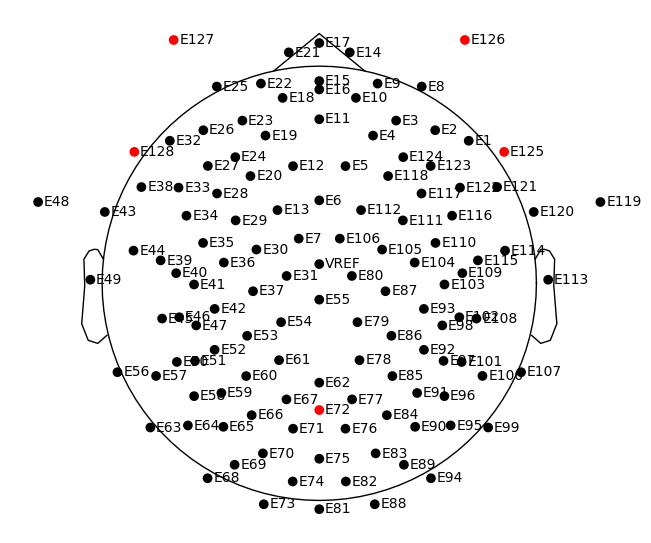

Reading 0 ... 522999  =      0.000 ...   522.999 secs...
Applying ICA to Raw instance
    Transforming to ICA space (108 components)
    Zeroing out 30 ICA components
    Projecting back using 124 PCA components
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done  71 tasks      | elapsed:    0.7s


Setting channel interpolation method to {'eeg': 'spline'}.
Interpolating bad channels.
    Automatic origin fit: head of radius 99.1 mm
Computing interpolation matrix from 124 sensor positions
Interpolating 5 sensors
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | sub-10043F1_ses-01_task-TO_run-1_eeg.edf, 176 x 523000 (523.0 s), ~702.5 MB, data loaded>

In [14]:
ll_state = ll.LosslessPipeline()
ll_state = ll_state.load_ll_derivative(bids_path)
bids_path_str=str(bids_path)
# Merge marks down to bads (aka manual)
ll_qcr = ll_state.raw.copy()
manual = []
for flag_type in ll_state.flags['ch']:
    manual.extend(ll_state.flags['ch'][flag_type])
print(ll_state.flags['ch'])
ll_qcr.info['bads'].extend(manual)
ll_qcr.info['bads'] = list(set(ll_qcr.info['bads']))

fig = ll_qcr.plot_sensors(show_names=True)

# Read the ICLabel info from file and add to exclude
df = pd.read_csv(bids_path_str.replace('_eeg.edf', '_iclabels.tsv'), sep='\t')
ll_state.ica2.exclude = list(df[df['ic_type'].str.match('eog|muscle|ch_noise|ecg')].index)

# Load the data and apply the ICA
ll_qcr.load_data()
ll_state.ica2.apply(ll_qcr)
ll_qcr = ll_qcr.filter(l_freq=1.0, h_freq=50.0)
ll_qcr = ll_qcr.interpolate_bads()
ll_qcr = ll_qcr.set_eeg_reference(ref_channels="average")
ll_qcr

# Segment the data to 'to_s_d' and 'to_t_d'

In [16]:
# Relabel condition vars for niceness
eeg_event_dict['to/visual/disp/to_s_d'] = eeg_event_dict.pop('to_s_d')
eeg_event_dict['to/visual/disp/to_t_d'] = eeg_event_dict.pop('to_t_d')

In [18]:
# Epoch structure is created for ALL events, then you 'segment' by indexing into it
epochs = mne.Epochs(ll_qcr, eeg_events, event_id=eeg_event_dict, tmin=-1, tmax=2.0, on_missing='warn', event_repeated='drop')
epochs = epochs[['to_s_d', 'to_t_d']]
display(epochs)
epochs.save(project_path + pylossless_path + postproc_path + 'epoch_fif_files/TO/' + bids_path.basename + '_epo.fif', overwrite=True)

Multiple event values for single event times found. Keeping the first occurrence and dropping all others.
Not setting metadata
900 matching events found
Setting baseline interval to [-1.0, 0.0] s
Applying baseline correction (mode: mean)
0 projection items activated


<Epochs | 218 events (good & bad), -1 – 2 s (baseline -1 – 0 s), ~220 kB, data not loaded,
 'to/visual/disp/to_s_d': 194
 'to/visual/disp/to_t_d': 24>

Using data from preloaded Raw for 218 events and 3001 original time points ...
2 bad epochs dropped
Using data from preloaded Raw for 1 events and 3001 original time points ...
Using data from preloaded Raw for 216 events and 3001 original time points ...


In [19]:
evokeds = {'to_s_d': epochs['to_s_d'].average(), 'to_t_d': epochs['to_t_d'].average()}
mne.write_evokeds(project_path + pylossless_path + postproc_path + 'erp_fif_files/TO/' + bids_path.basename + '_erp.fif',list(evokeds.values()), overwrite=True)

# Plot ERP envelopes and topographies

No projector specified for this dataset. Please consider the method self.add_proj.


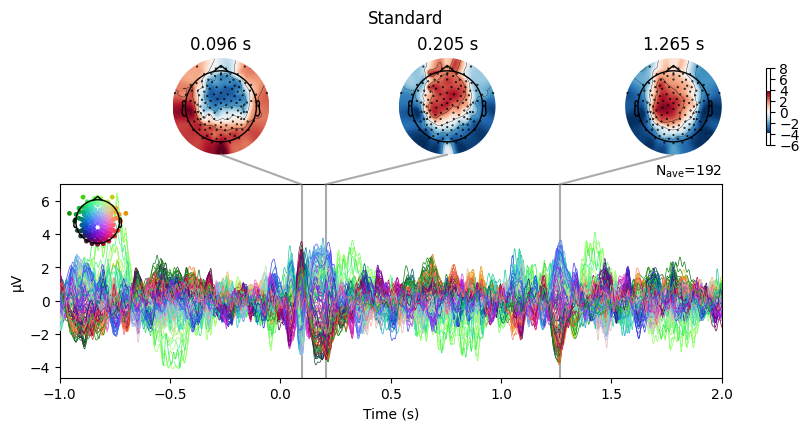

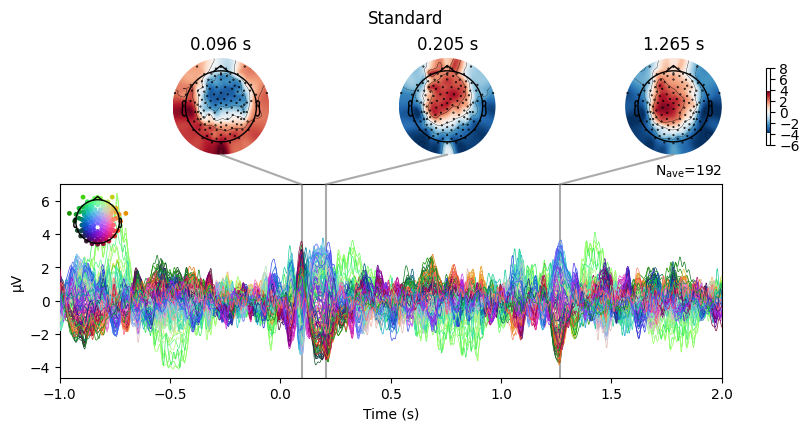

In [20]:
evokeds['to_s_d'].plot_joint(title='Standard')

No projector specified for this dataset. Please consider the method self.add_proj.


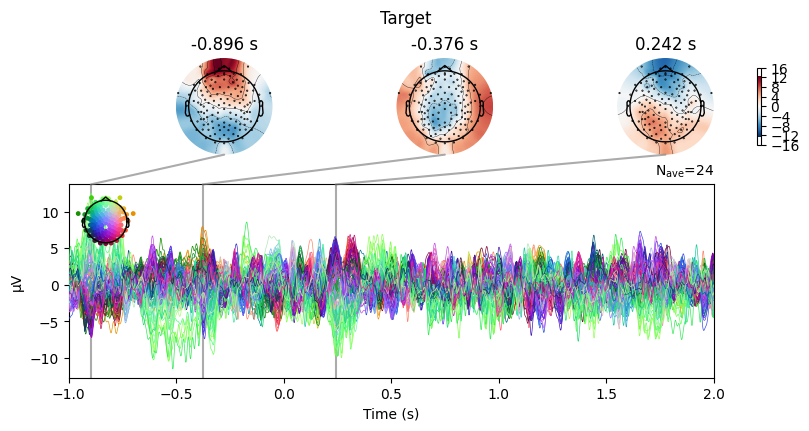

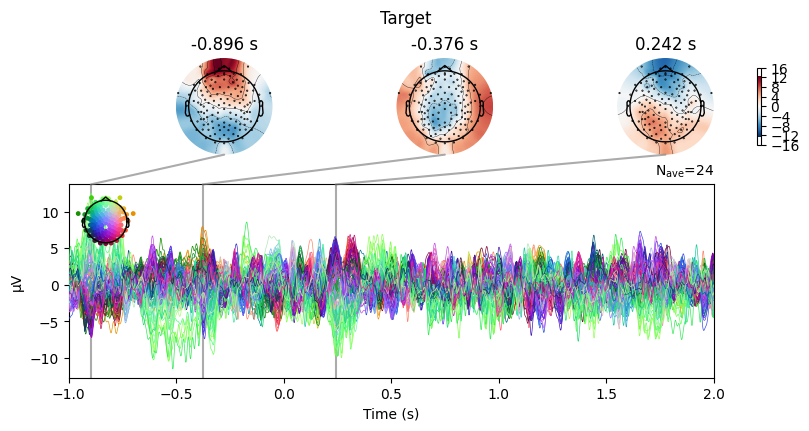

In [22]:
evokeds['to_t_d'].plot_joint(title='Target')

# Plot the ERP overlay

combining channels using "mean"
combining channels using "mean"


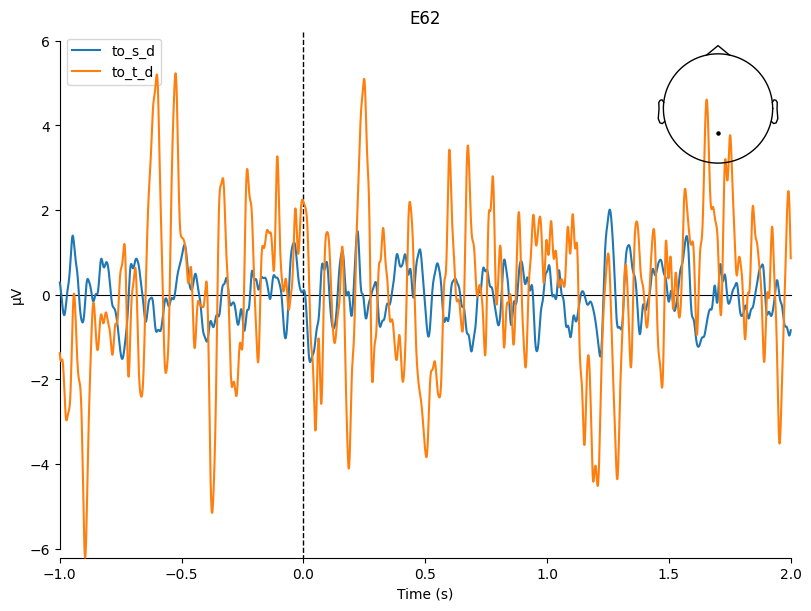

[<Figure size 800x600 with 2 Axes>]

In [23]:
# Plot ERP overlay
mne.viz.plot_compare_evokeds(evokeds, picks=['E62'], combine='mean')

In [25]:
#epochs_condition_1 = epochs['sv06']
#epochs_condition_2 = epochs['sv15']
ch_name = 'E62'

decim = 2
freqs = np.arange(3, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

#epochs_chan = epochs.pick_channels([ch_name])


In [26]:
decim = 2
freqs = np.arange(2, 50, 2)  # define frequencies of interest
n_cycles = freqs / 2

pow_1, itc_1 = mne.time_frequency.tfr_morlet(
    epochs['to_s_d'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

pow_2, itc_2 = mne.time_frequency.tfr_morlet(
    epochs['to_s_d'],
    freqs,
    picks=ch_name,
    n_cycles=n_cycles,
    decim=decim,
    return_itc=True,
    average=True,
)

itc_dat_1 = itc_1.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_1 = pow_1.data[0, :, :]  # only 1 channel as 3D matrix

itc_dat_2 = itc_2.data[0, :, :]  # only 1 channel as 3D matrix
pow_dat_2 = pow_2.data[0, :, :]  # only 1 channel as 3D matrix

NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Using data from preloaded Raw for 192 events and 3001 original time points ...
NOTE: tfr_morlet() is a legacy function. New code should use .compute_tfr(method="morlet").
Using data from preloaded Raw for 192 events and 3001 original time points ...


Text(0.5, 0, 'Time (ms)')

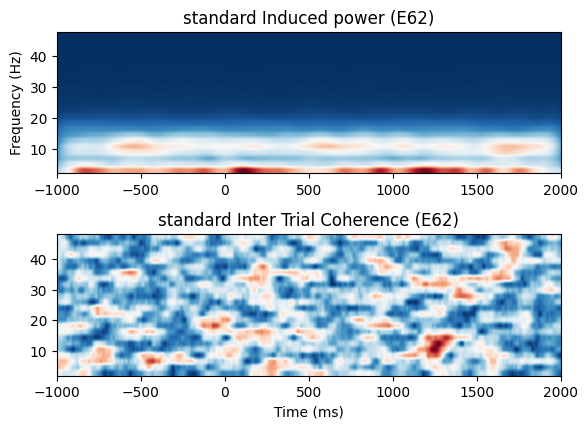

In [27]:
times = 1e3 * epochs['to_s_d'].times  # change unit to ms

fig1, (ax1t, ax1b) = plt.subplots(2, 1, figsize=(6, 4))
fig1.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax1t.imshow(
    pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1b.imshow(
    itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax1t.set_ylabel("Frequency (Hz)")
ax1t.set_title(f"standard Induced power ({ch_name})")
ax1b.set_title(f"standard Inter Trial Coherence ({ch_name})")
ax1b.set_xlabel("Time (ms)")

Text(0.5, 0, 'Time (ms)')

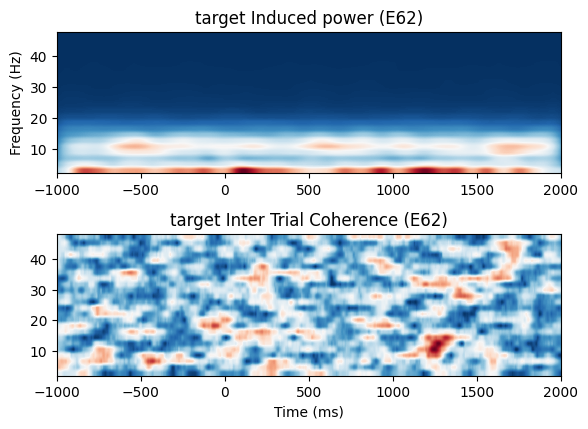

In [28]:
fig2, (ax2t, ax2b) = plt.subplots(2, 1, figsize=(6, 4))
fig2.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax2t.imshow(
    pow_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2b.imshow(
    itc_dat_2,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax2t.set_ylabel("Frequency (Hz)")
ax2t.set_title(f"target Induced power ({ch_name})")
ax2b.set_title(f"target Inter Trial Coherence ({ch_name})")
ax2b.set_xlabel("Time (ms)")


Text(0.5, 0, 'Time (ms)')

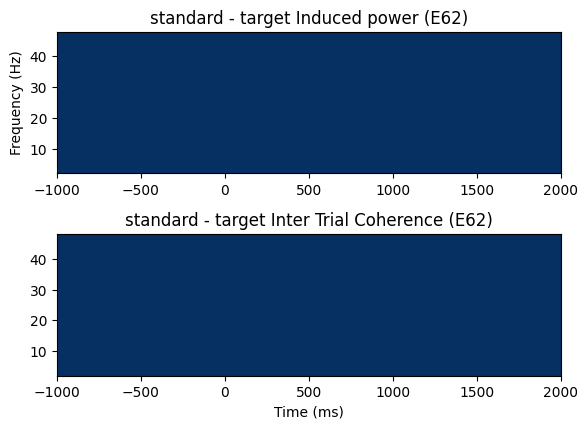

In [29]:
fig3, (ax3t, ax3b) = plt.subplots(2, 1, figsize=(6, 4))
fig3.subplots_adjust(0.12, 0.08, 0.96, 0.94, 0.2, 0.43)

ax3t.imshow(
    pow_dat_2 - pow_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3b.imshow(
    itc_dat_2 - itc_dat_1,
    extent=[times[0], times[-1], freqs[0], freqs[-1]],
    aspect="auto",
    origin="lower",
    cmap="RdBu_r",
)

ax3t.set_ylabel("Frequency (Hz)")
ax3t.set_title(f"standard - target Induced power ({ch_name})")
ax3b.set_title(f"standard - target Inter Trial Coherence ({ch_name})")
ax3b.set_xlabel("Time (ms)")


In [ ]:
!jupyter nbconvert --output {"session_reports/" + bids_path.basename + ".html"} --TagRemovePreprocessor.remove_all_outputs_tags='{"exclude"}' --no-input --to html session_seg_vp.ipynb